In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:

def get_drawdown(p):
    """
    计算净值回撤
    """
    T = len(p)
    hmax = [p[0]]
    for t in range(1, T):
        hmax.append(np.nanmax([p[t], hmax[t - 1]]))
    dd = [p[t] / hmax[t] - 1 for t in range(T)]

    return dd


def cal_period_perf_indicator(adjnav):
    """
    计算区间业绩指标:输入必须是日频净值
    """

    if type(adjnav) == pd.DataFrame:
        res = pd.DataFrame(index=adjnav.columns, columns=['AnnRet', 'AnnVol', 'SR', 'MaxDD', 'Calmar'])
        for col in adjnav:
            res.loc[col] = cal_period_perf_indicator(adjnav[col])

        return res

    ret = adjnav.pct_change()
    #annret = np.nanmean(ret) * 242 # 单利
    annret = (adjnav[-1] / adjnav[0]) ** (242/len(adjnav)) - 1 # 复利
    annvol = np.nanstd(ret) * np.sqrt(242)
    sr = annret / annvol
    dd = get_drawdown(adjnav)
    mdd = np.nanmin(dd)
    calmar = annret / -mdd

    return [annret, annvol, sr, mdd, calmar]

def datestr2dtdate(datestr):
    # 日期格式转换：'yyyy-mm-dd'转为datetime.date
    return datetime.datetime.strptime(datestr, '%Y-%m-%d').date()


In [3]:
# 从csv文件获取指数价格数据
index_data = pd.read_csv('./四种指数价格历史数据.csv').set_index('datetime')
index_data.index = [datestr2dtdate(e) for e in index_data.index]

index_data

,csi1000,csi500,hs300,sse
2004-12-31,1000.0000,1000.0000,1000.0000,1266.4960
2005-01-04,989.9840,986.9270,982.7940,1242.7740
2005-01-05,1013.5830,1003.6330,992.5640,1251.9370
2005-01-06,1005.4650,994.5950,983.1740,1239.4300
2005-01-07,1011.7400,997.6060,983.9580,1244.7460
...,...,...,...,...
2021-08-12,7657.5268,7095.2024,4973.3509,3524.7374
2021-08-13,7641.9169,7088.8876,4945.9829,3516.2989
2021-08-16,7568.1374,7052.4876,4941.0676,3517.3447
2021-08-17,7360.0330,6894.4042,4837.4034,3446.9760


                hs300       ret     asset  N_day_ret  pos  stgy_ret      stgy
2004-12-31  1000.0000       NaN  1.000000        NaN  0.5       NaN  1.000000
2005-01-04   982.7940 -0.017206  0.982794        NaN  0.5 -0.008603  0.991397
2005-01-05   992.5640  0.009941  0.992564        NaN  0.5  0.004971  0.996325
2005-01-06   983.1740 -0.009460  0.983174        NaN  0.5 -0.004730  0.991612
2005-01-07   983.9580  0.000797  0.983958        NaN  0.5  0.000399  0.992007
...               ...       ...       ...        ...  ...       ...       ...
2021-08-12  4973.3509 -0.008372  4.973351  -0.034575  0.5 -0.004186  6.882054
2021-08-13  4945.9829 -0.005503  4.945983  -0.029204  0.5 -0.002751  6.863118
2021-08-16  4941.0676 -0.000994  4.941068  -0.033720  0.5 -0.000497  6.859708
2021-08-17  4837.4034 -0.020980  4.837403  -0.053159  0.5 -0.010490  6.787749
2021-08-18  4894.2384  0.011749  4.894238  -0.048562  0.0  0.000000  6.787749

[4043 rows x 7 columns]
         AnnRet    AnnVol        SR    

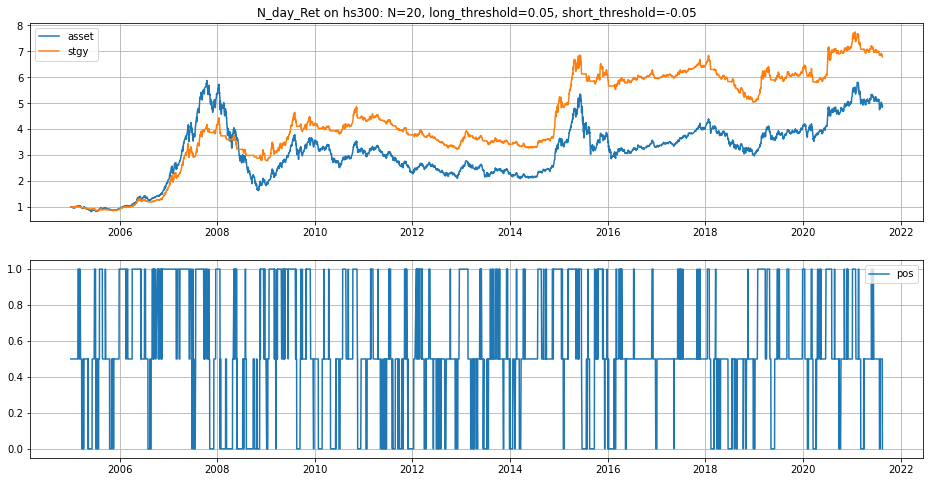

In [4]:
################################################################
# 近期涨幅 
index_id = 'hs300'
N = 20
long_threshold = 0.05
short_threshold = -0.05

df = index_data.loc[:,[index_id]]
df['ret'] = df[index_id].pct_change()
df['asset'] = (1+df['ret']).cumprod().fillna(1)
df['N_day_ret'] = df['asset'] / df['asset'].shift(N) - 1
df['pos'] = [1 if e>long_threshold else 0 if e<short_threshold else 0.5 for e in df['N_day_ret'].shift(1)]
df['stgy_ret'] = df['ret'] * df['pos']
df['stgy'] = (1+df['stgy_ret']).cumprod().fillna(1)

print(df)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(2,1,1)
df.loc[:,['asset','stgy']].plot(ax=ax1, grid=True, title='N_day_Ret on %s: N=%d, long_threshold=%.2f, short_threshold=%.2f' % (index_id, N,long_threshold,short_threshold))
ax2 = fig.add_subplot(2,1,2)
df.loc[:,['pos']].plot(ax=ax2, grid=True)
res = cal_period_perf_indicator(df.loc[:,['asset','stgy']])
print(res)

                hs300       ret     asset       MA1       MA2   MA1/MA2  pos  \
2004-12-31  1000.0000       NaN  1.000000       NaN       NaN       NaN  0.5   
2005-01-04   982.7940 -0.017206  0.982794       NaN       NaN       NaN  0.5   
2005-01-05   992.5640  0.009941  0.992564       NaN       NaN       NaN  0.5   
2005-01-06   983.1740 -0.009460  0.983174       NaN       NaN       NaN  0.5   
2005-01-07   983.9580  0.000797  0.983958       NaN       NaN       NaN  0.5   
...               ...       ...       ...       ...       ...       ...  ...   
2021-08-12  4973.3509 -0.008372  4.973351  4.954585  5.120234  0.967648  0.5   
2021-08-13  4945.9829 -0.005503  4.945983  4.968066  5.116227  0.971041  0.5   
2021-08-16  4941.0676 -0.000994  4.941068  4.968799  5.113009  0.971796  0.5   
2021-08-17  4837.4034 -0.020980  4.837403  4.959094  5.107706  0.970904  0.5   
2021-08-18  4894.2384  0.011749  4.894238  4.950633  5.100635  0.970591  0.5   

            stgy_ret      stgy  
2004-1

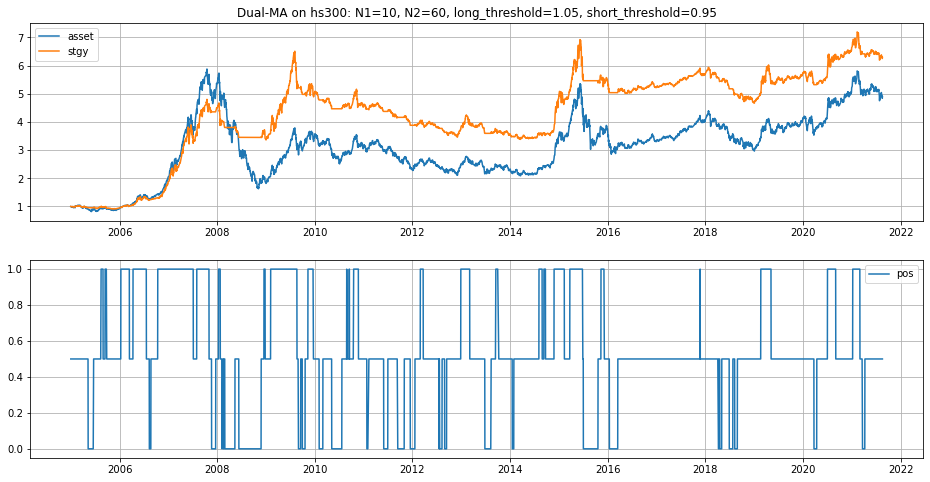

In [5]:

################################################################
# 双均线系统
index_id = 'hs300'
N1 = 10
N2 = 60
long_threshold = 1.05
short_threshold = 0.95

df = index_data.loc[:,[index_id]]
df['ret'] = df[index_id].pct_change()
df['asset'] = (1+df['ret']).cumprod().fillna(1)
df['ret'] = df['asset'].pct_change()
df['MA1'] = df['asset'].rolling(window=N1).mean()
df['MA2'] = df['asset'].rolling(window=N2).mean()
df['MA1/MA2'] = df['MA1'] / df['MA2']
df['pos'] = [1 if e>long_threshold else 0 if e<short_threshold else 0.5 for e in df['MA1/MA2'].shift(1)]
df['stgy_ret'] = df['ret'] * df['pos']
df['stgy'] = (1+df['stgy_ret']).cumprod().fillna(1)

print(df)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(2,1,1)
df.loc[:,['asset','stgy']].plot(ax=ax1, grid=True, title='Dual-MA on %s: N1=%d, N2=%d, long_threshold=%.2f, short_threshold=%.2f' % (index_id, N1, N2, long_threshold, short_threshold))
ax2 = fig.add_subplot(2,1,2)
df.loc[:,['pos']].plot(ax=ax2, grid=True)
res = cal_period_perf_indicator(df.loc[:,['asset','stgy']])
print(res)

                hs300       ret     asset        MA       std        up  \
2004-12-31  1000.0000       NaN  1.000000       NaN       NaN       NaN   
2005-01-04   982.7940 -0.017206  0.982794       NaN       NaN       NaN   
2005-01-05   992.5640  0.009941  0.992564       NaN       NaN       NaN   
2005-01-06   983.1740 -0.009460  0.983174       NaN       NaN       NaN   
2005-01-07   983.9580  0.000797  0.983958       NaN       NaN       NaN   
...               ...       ...       ...       ...       ...       ...   
2021-08-12  4973.3509 -0.008372  4.973351  4.976775  0.121069  5.218914   
2021-08-13  4945.9829 -0.005503  4.945983  4.969336  0.117969  5.205273   
2021-08-16  4941.0676 -0.000994  4.941068  4.960714  0.113078  5.186871   
2021-08-17  4837.4034 -0.020980  4.837403  4.947135  0.110615  5.168365   
2021-08-18  4894.2384  0.011749  4.894238  4.934645  0.100886  5.136417   

                down  pos  stgy_ret      stgy  
2004-12-31       NaN  0.0       NaN  1.000000  
200

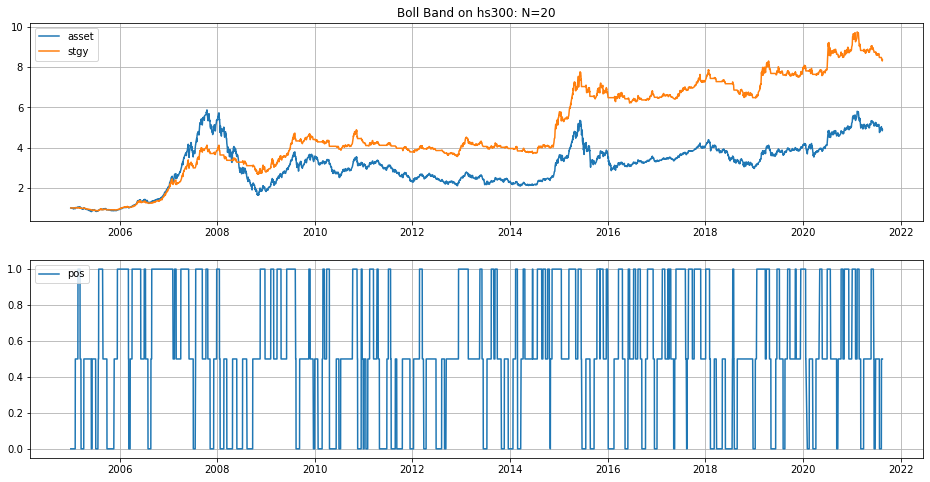

In [6]:
################################################################
# 布林带
N = 20
index_id = 'hs300'

df = index_data.loc[:,[index_id]]
df['ret'] = df[index_id].pct_change()
df['asset'] = (1+df['ret']).cumprod().fillna(1)
df['ret'] = df['asset'].pct_change()
df['MA'] = df['asset'].rolling(window=N).mean()
df['std'] = df['asset'].rolling(window=N).std()
df['up'] = df['MA'] + 2 * df['std']
df['down'] = df['MA'] - 2 * df['std']
df['pos'] = 0
for i in range(1,len(df)):
    t = df.index[i]
    t0 = df.index[i-1]
    if df.loc[t0,'asset'] > df.loc[t0,'up']:
        df.loc[t,'pos'] = 1
    elif df.loc[t0,'asset'] < df.loc[t0,'down']:
        df.loc[t,'pos'] = 0
    elif df.loc[t0,'pos']==1 and df.loc[t0,'asset']<df.loc[t0,'MA']:
        df.loc[t,'pos'] = 0.5
    elif df.loc[t0,'pos']==0 and df.loc[t0,'asset']>df.loc[t0,'MA']:
        df.loc[t,'pos'] = 0.5
    else:
        df.loc[t,'pos'] = df.loc[t0,'pos']
df['stgy_ret'] = df['ret'] * df['pos']
df['stgy'] = (1+df['stgy_ret']).cumprod().fillna(1)

print(df)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(2,1,1)
df.loc[:,['asset','stgy']].plot(ax=ax1, grid=True, title='Boll Band on %s: N=%d' % (index_id, N))
ax2 = fig.add_subplot(2,1,2)
df.loc[:,['pos']].plot(ax=ax2, grid=True)
res = cal_period_perf_indicator(df.loc[:,['asset','stgy']])
print(res)

         AnnRet    AnnVol        SR     MaxDD    Calmar
asset  0.100956  0.244424  0.413036 -0.639139  0.157956
stgy   0.082502  0.176235  0.468133 -0.312061  0.264376


/Users/pangjiawei/.pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 34746 (\N{CJK UNIFIED IDEOGRAPH-87BA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pangjiawei/.pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32441 (\N{CJK UNIFIED IDEOGRAPH-7EB9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pangjiawei/.pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38050 (\N{CJK UNIFIED IDEOGRAPH-94A2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


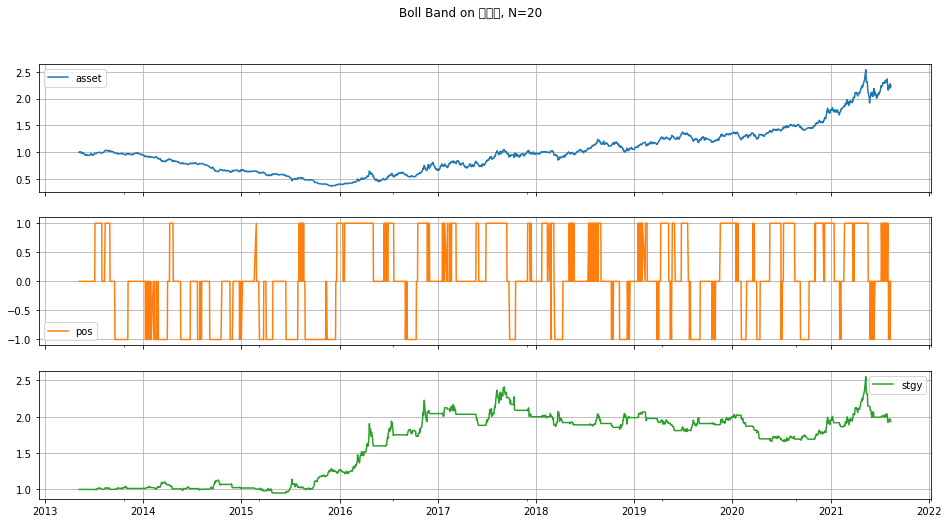

In [7]:
#####################################################

# 从csv文件获取期货价格数据
future_data = pd.read_csv('./期货主连数据.csv').set_index('datetime')
future_data.index = [datestr2dtdate(e) for e in future_data.index]


# 布林带
N = 20
future_name = '螺纹钢'

df = future_data.loc[:,['close']].rename(columns={'close':'asset'})
df['ret'] = df['asset'].pct_change()
df['MA'] = df['asset'].rolling(window=N).mean()
df['std'] = df['asset'].rolling(window=N).std()
df['up'] = df['MA'] + 2 * df['std']
df['down'] = df['MA'] - 2 * df['std']
df['pos'] = 0
for i in range(2,len(df)):
    t = df.index[i]
    t0 = df.index[i-2]
    if df.loc[t0,'asset'] > df.loc[t0,'up']:
        df.loc[t,'pos'] = 1
    elif df.loc[t0,'asset'] < df.loc[t0,'down']:
        df.loc[t,'pos'] = -1
    elif df.loc[t0,'pos']==1 and df.loc[t0,'asset']<df.loc[t0,'MA']:
        df.loc[t,'pos'] = 0
    elif df.loc[t0,'pos']==-1 and df.loc[t0,'asset']>df.loc[t0,'MA']:
        df.loc[t,'pos'] = 0
    else:
        df.loc[t,'pos'] = df.loc[t0,'pos']
df['stgy_ret'] = df['ret'] * df['pos']
df['stgy'] = (1+df['stgy_ret']).cumprod().fillna(1)
df.loc[:,['asset', 'pos', 'stgy']].plot(figsize=(16,8), subplots=True, grid=True, title='Boll Band on %s, N=%d' % (future_name,N))
res = cal_period_perf_indicator(df.loc[:,['asset', 'stgy']])
print(res)